#Question 1

#Part A

In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
import time

In [2]:
torch.manual_seed(42)
training_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True)
testing_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 89719422.53it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 30253669.79it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 25738050.55it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 2190975.13it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [3]:
training_size = int(0.8 * len(training_dataset))
validation_size = len(training_dataset) - training_size
training_dataset, validation_dataset = torch.utils.data.random_split(training_dataset, [training_size, validation_size])

In [4]:
training_data = torch.from_numpy(training_dataset.dataset.data.numpy())
mean = training_data.float().mean() / 255
std = training_data.float().std() / 255

In [5]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.RandomRotation(5),
    torchvision.transforms.RandomCrop(size=28, padding=2),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[mean], std=[std])
])

test_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[mean], std=[std])
])

In [6]:
training_dataset.dataset.transform = train_transform
validation_dataset.dataset.transform = test_transform
testing_dataset.transform = test_transform

#Part B

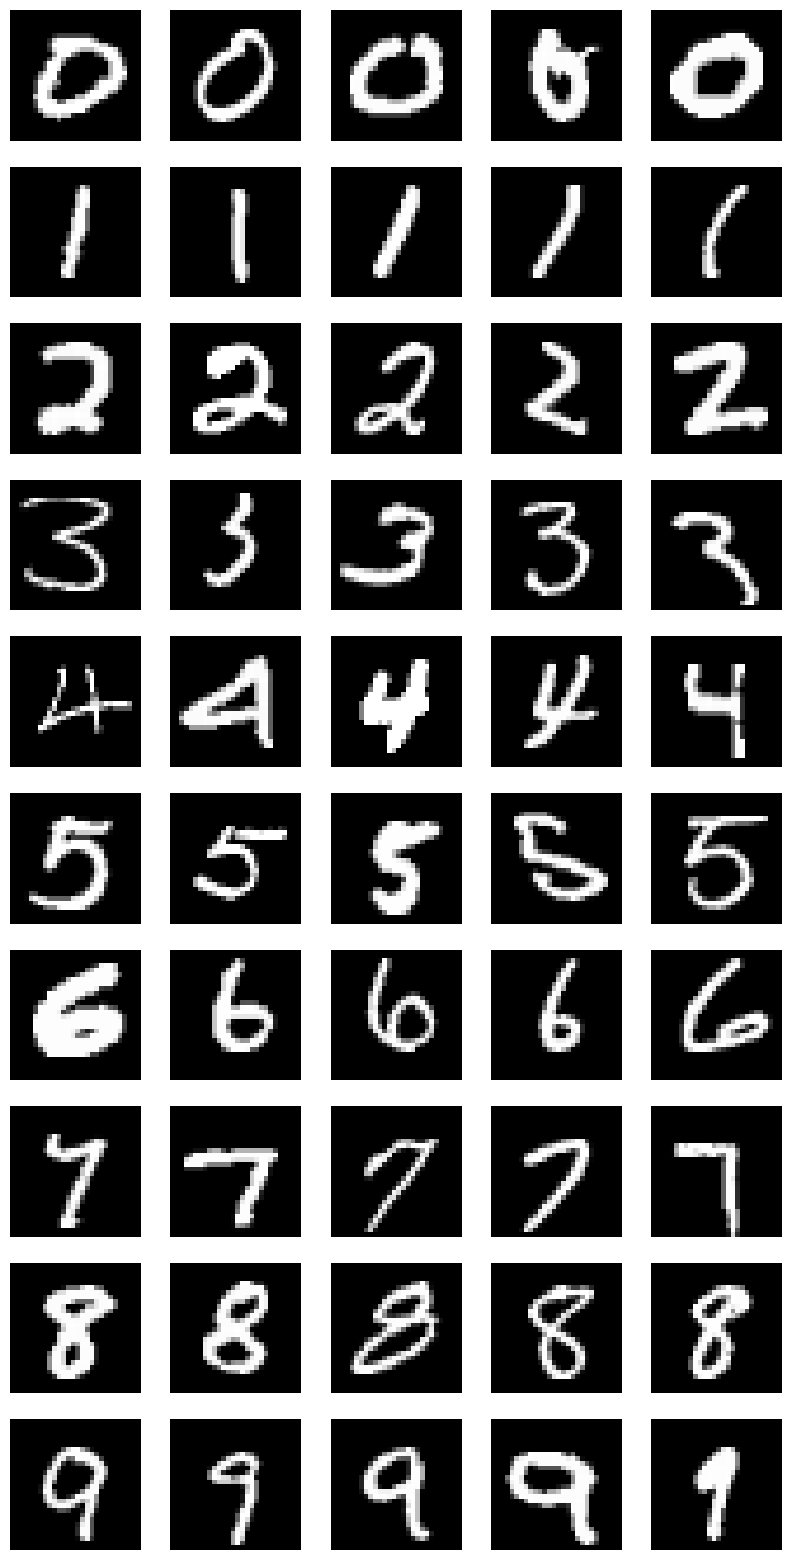

In [7]:
images = {i: [] for i in range(10)}

for image, label in training_dataset:
    if len(images[label]) < 5:
        images[label].append(image)

fig, axs = plt.subplots(10, 5, figsize=(10, 20))
for i in range(10):
    for j in range(5):
        axs[i, j].imshow(images[i][j].squeeze(), cmap='gray')
        axs[i, j].axis('off')
plt.show()

#Part C

In [8]:
training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=64, shuffle=True)
testing_loader = torch.utils.data.DataLoader(testing_dataset, batch_size=64, shuffle=False)

In [9]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten input tensor
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [10]:
model = MLP(input_dim=28*28, hidden_dim=250, output_dim=10)
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of Trainable Parameters:",num_params)

Number of Trainable Parameters: 261510


In [11]:
model = MLP(input_dim=28*28, hidden_dim=250, output_dim=10)
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

In [12]:
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=64, shuffle=False)

#Part D

In [13]:
training_loss = []
training_acc = []
validation_loss = []
validation_acc = []

best_validation_acc = 0
best_model = None

num_epochs = 5
for epoch in range(1,num_epochs+1):
    model.train()
    for batch_idx, (data, target) in enumerate(training_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        pred = output.argmax(dim=1, keepdim=True)
        correct = pred.eq(target.view_as(pred)).sum().item()
        accuracy = correct / len(target)
        training_loss.append(loss.item())
        training_acc.append(accuracy)

    model.eval()
    val_loss_epoch = 0
    val_correct = 0
    for data, target in validation_loader:
        output = model(data)
        val_loss_epoch += criterion(output, target).item()
        pred = output.argmax(dim=1, keepdim=True)
        val_correct += pred.eq(target.view_as(pred)).sum().item()
    validation_loss.append(val_loss_epoch / len(validation_loader))
    validation_accuracy = val_correct / len(validation_loader.dataset)
    validation_acc.append(validation_accuracy)

    if validation_accuracy > best_validation_acc:
        best_val_acc = validation_accuracy
        best_model = model.state_dict()

    print("Epoch",epoch,": Training Loss:",training_loss[-1],", Validation Loss:", validation_loss[-1],", Validation Accuracy:",validation_acc[-1])

torch.save(best_model, 'best_model.pt')

Epoch 1 : Training Loss: 0.2039342224597931 , Validation Loss: 0.13112191573538362 , Validation Accuracy: 0.961
Epoch 2 : Training Loss: 0.19848671555519104 , Validation Loss: 0.12033595695616082 , Validation Accuracy: 0.9655
Epoch 3 : Training Loss: 0.0499301515519619 , Validation Loss: 0.10879878449362722 , Validation Accuracy: 0.9668333333333333
Epoch 4 : Training Loss: 0.021326759830117226 , Validation Loss: 0.12004944905415772 , Validation Accuracy: 0.96775
Epoch 5 : Training Loss: 0.13232024013996124 , Validation Loss: 0.10849056286771999 , Validation Accuracy: 0.969


In [14]:
model.load_state_dict(best_model)
model.eval()
test_correct = 0
for data, target in testing_loader:
    output = model(data)
    pred = output.argmax(dim=1, keepdim=True)
    test_correct += pred.eq(target.view_as(pred)).sum().item()
test_acc = test_correct / len(testing_dataset)
print(f"Test accuracy: {test_acc:.4f}")

Test accuracy: 0.9715


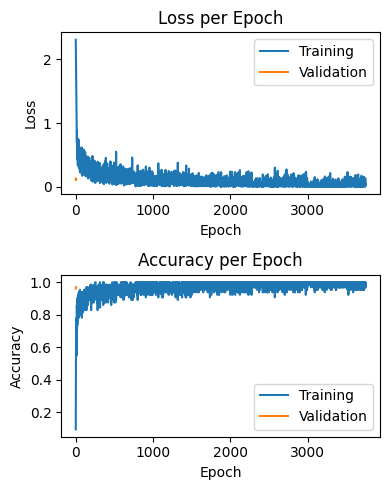

In [15]:
fig, ax = plt.subplots(2, 1, figsize=(4, 5))

ax[0].plot(training_loss, label='Training')
ax[0].plot(validation_loss, label='Validation')
ax[0].set_title('Loss per Epoch')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(training_acc, label='Training')
ax[1].plot(validation_acc, label='Validation')
ax[1].set_title('Accuracy per Epoch')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

plt.tight_layout()
plt.show()

#Part E

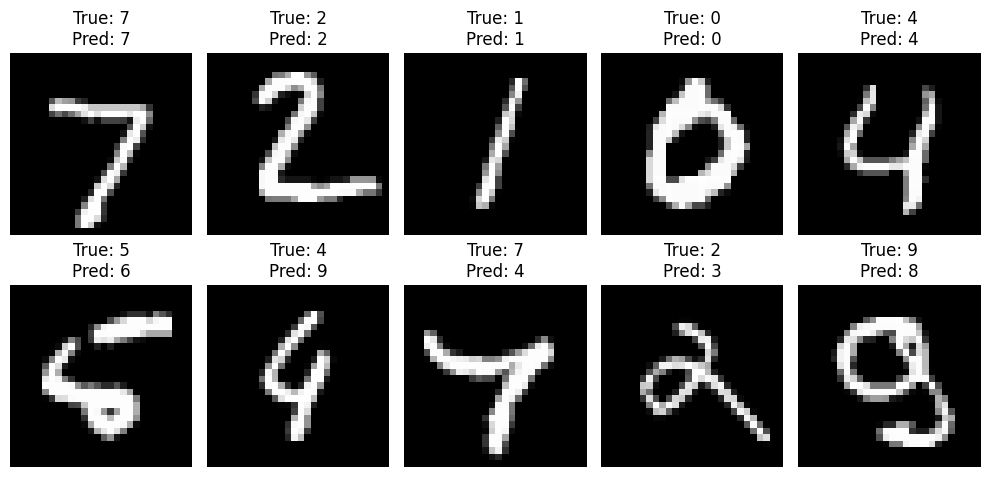

In [16]:
num_correct = 0
num_incorrect = 0
fig, ax = plt.subplots(2, 5, figsize=(10, 5))
for data, target in testing_loader:
    output = model(data)
    pred = output.argmax(dim=1, keepdim=True)
    for i in range(len(target)):
        if pred[i] == target[i]:
            if num_correct >= 5:
                continue
            ax[0, num_correct].imshow(data[i].numpy().squeeze(), cmap='gray')
            ax[0, num_correct].set_title(f"True: {target[i]}\nPred: {pred[i][0]}")
            ax[0, num_correct].axis('off')
            num_correct += 1
        else:
            if num_incorrect >= 5:
                continue
            ax[1, num_incorrect].imshow(data[i].numpy().squeeze(), cmap='gray')
            ax[1, num_incorrect].set_title(f"True: {target[i]}\nPred: {pred[i][0]}")
            ax[1, num_incorrect].axis('off')
            num_incorrect += 1
    if num_correct >= 5 and num_incorrect >= 5:
        break
plt.tight_layout()
plt.show()

#Question 2

#Part A

In [18]:
df = pd.read_csv('/content/drive/MyDrive/Lab_Data/abalone.csv')
df

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7
...,...,...,...,...,...,...,...,...,...
4172,F,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11
4173,M,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10
4174,M,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9
4175,F,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10


In [19]:
#Encoding nominal datatype
df['Sex'] = df['Sex'].replace(to_replace='M',value=0)
df['Sex'] = df['Sex'].replace(to_replace='F',value=1)
df['Sex'] = df['Sex'].replace(to_replace='I',value=2)
df

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15
1,0,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7
2,1,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9
3,0,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10
4,2,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7
...,...,...,...,...,...,...,...,...,...
4172,1,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11
4173,0,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10
4174,0,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9
4175,1,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10


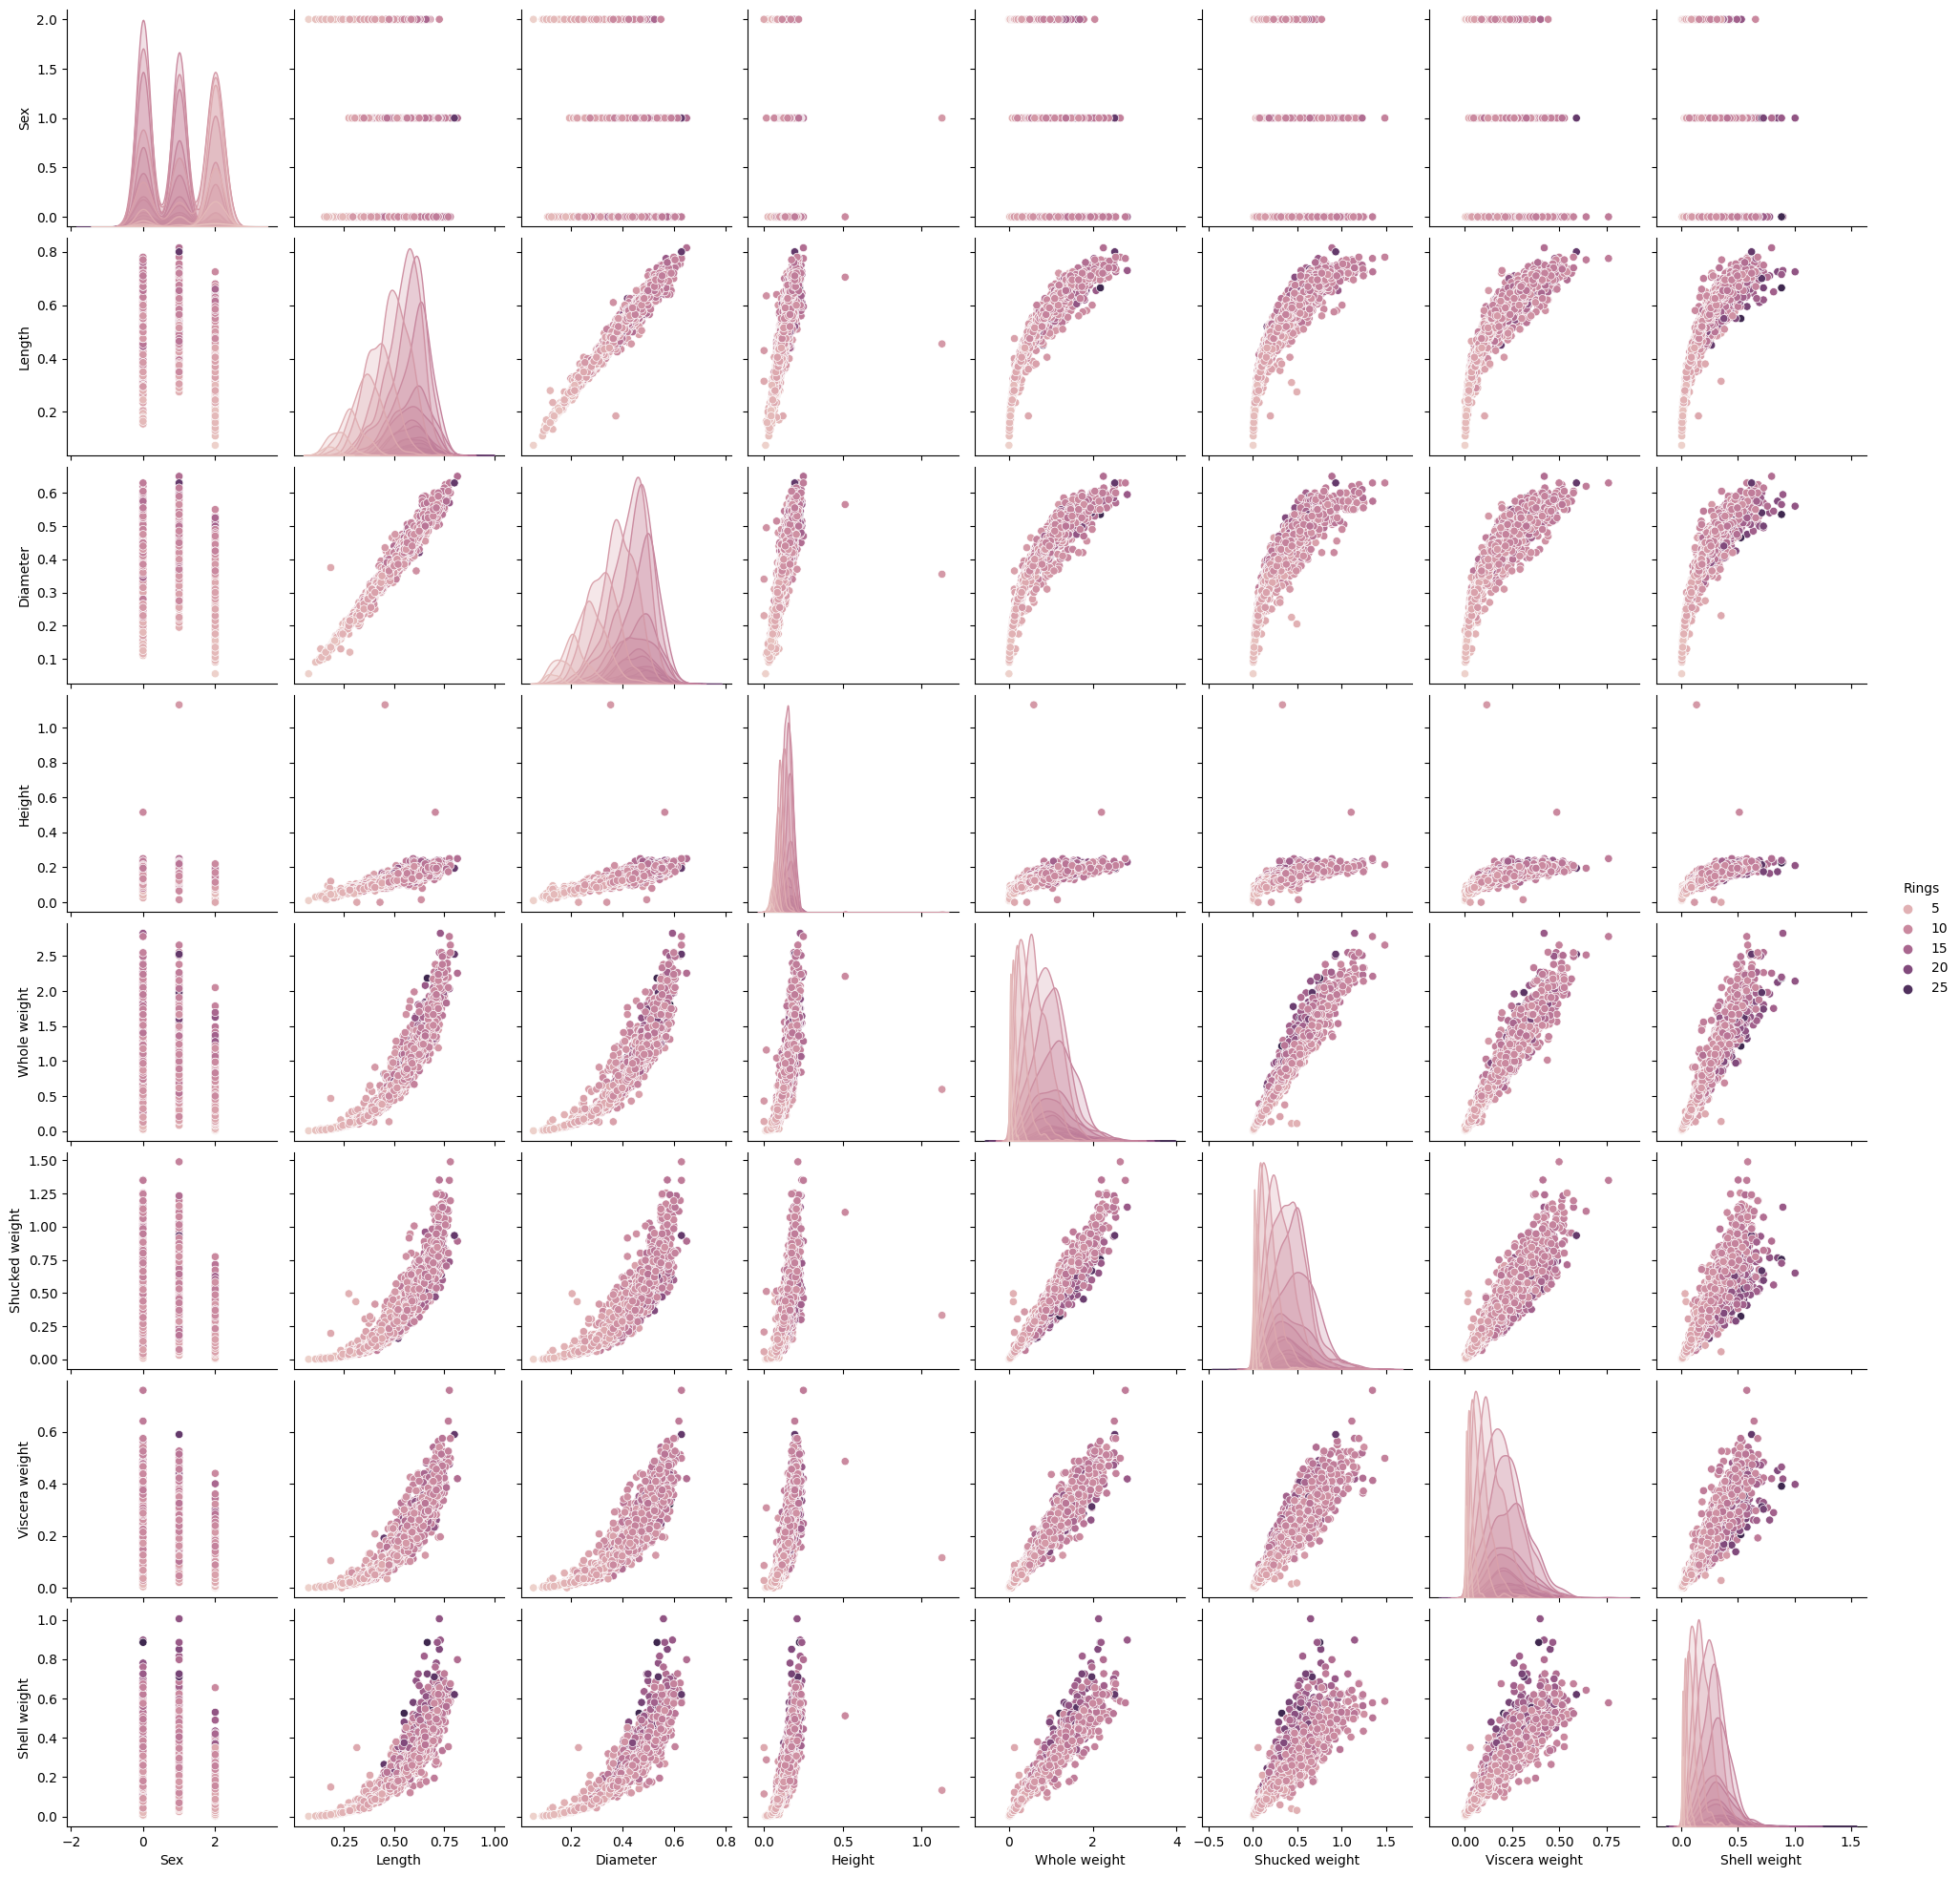

In [20]:
#visualization
sns.pairplot(df,hue='Rings')

In [21]:
X = df.drop('Rings',axis=1)
y = df['Rings']

In [22]:
X_train, X_rem, y_train, y_rem = train_test_split(X,y, train_size=0.7)
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.67)

#Part B & C

In [23]:
class MLP:
    
    def __init__(self, input_size, hidden_size, output_size, learning_rate=0.1):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.learning_rate = learning_rate
        
        # Initialize weights and biases for the hidden layer and output layer
        self.hidden_weights = np.random.randn(self.input_size, self.hidden_size)
        self.hidden_bias = np.random.randn(1, self.hidden_size)
        self.output_weights = np.random.randn(self.hidden_size, self.output_size)
        self.output_bias = np.random.randn(1, self.output_size)
        
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def sigmoid_derivative(self, x):
        return x * (1 - x)
    
    def relu(self, x):
        return np.maximum(0, x)
    
    def relu_derivative(self, x):
        x[x <= 0] = 0
        x[x > 0] = 1
        return x
    
    def tanh(self, x):
        return np.tanh(x)
    
    def tanh_derivative(self, x):
        return 1 - np.square(np.tanh(x))
    
    def softmax(self, x):
        exp_x = np.exp(x)
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)
    
    def forward(self, X):
        # Forward propagate input through hidden layer
        self.hidden_layer = np.dot(X.T, self.hidden_weights) + self.hidden_bias
        self.hidden_output = self.relu(self.hidden_layer) # or sigmoid or tanh
        
        # Forward propagate hidden layer output through output layer
        self.output_layer = np.dot(self.hidden_output, self.output_weights) + self.output_bias
        self.output = self.softmax(self.output_layer)
        
        return self.output
    
    def backward(self, X, y, output):
        # Calculate error in output layer
        output_error = y - output
        
        # Calculate error in hidden layer
        hidden_error = np.dot(output_error, self.output_weights.T)
        hidden_error *= self.relu_derivative(self.hidden_output) # or sigmoid_derivative or tanh_derivative
        
        # Calculate gradients for weights and biases
        output_weights_gradient = np.dot(self.hidden_output.T, output_error)
        output_bias_gradient = np.sum(output_error, axis=0, keepdims=True)
        hidden_weights_gradient = np.dot(X.T, hidden_error)
        hidden_bias_gradient = np.sum(hidden_error, axis=0, keepdims=True)
        
        # Update weights and biases
        self.hidden_weights += self.learning_rate * hidden_weights_gradient
        self.hidden_bias += self.learning_rate * hidden_bias_gradient
        self.output_weights += self.learning_rate * output_weights_gradient
        self.output_bias += self.learning_rate * output_bias_gradient
        
    def train(self, X, y, epochs):
        losses = []
        accuracies = []
        
        for epoch in range(epochs):
            # Forward propagate input
            output = self.forward(X)
            
            # Back propagate error
            self.backward(X, y, output)
            
            # Compute loss and accuracy
            loss = -np.mean(y * np.log(output))
            losses.append(loss)
            predictions = np.argmax(output, axis=1)
            accuracy = np.mean(predictions == np.argmax(y, axis=1))
            accuracies.append(accuracy)
            
            # Print progress
            if epoch % 100 == 0:
                print(f"Epoch {epoch}: Loss = {loss:.4f}, Accuracy = {accuracy:.4f}")
        
        return losses, accuracies